# Introduction

The 2019-nCoV is a contagious coronavirus that hailed from Wuhan (Hubei province), China. This new strain of virus has striked fear in many countries as cities are quarantined and hospitals are overcrowded.

This dataset contains data that was released by Johns Hopkins University.

The Dataset is updated constantly so I will rerun this Kernel to visualize the new results.

The Kernel is also showing how we can use Folium to display geographically distributed data.

In [1]:
import datetime as dt
dt_string = dt.datetime.now().strftime("%d/%m/%Y")
print(f"Kernel last updated: {dt_string}")

Kernel last updated: 24/02/2020


# Analysis preparation

## Load packages

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime as dt
import folium
%matplotlib inline

## Load the data

There are multiple files in the coronavirus data folder, we will take the last updated one.
We also include GeoJSON data for China and for World.

In [3]:
print(os.listdir('/kaggle/input'))
DATA_FOLDER = "/kaggle/input/2019-coronavirus-dataset-01212020-01262020"
print(os.listdir(DATA_FOLDER))
DATA_2_FOLDER = "/kaggle/input/novel-corona-virus-2019-dataset"
print(os.listdir(DATA_2_FOLDER))
GEO_DATA = "/kaggle/input/china-regions-map"
print(os.listdir(GEO_DATA))
WD_GEO_DATA = '/kaggle/input/python-folio-country-boundaries'
print(os.listdir(WD_GEO_DATA))
CN_GEO_DATA = '/kaggle/input/coronavirus-latlon-dataset'
print(os.listdir(CN_GEO_DATA))

['novel-corona-virus-2019-dataset', '2019-coronavirus-dataset-01212020-01262020', 'coronavirus-latlon-dataset', 'python-folio-country-boundaries', 'china-regions-map']
['2019_nCoV_20200121_20200128.csv', '2019_nC0v_20200121_20200126_cleaned.csv', '2019_nCoV_20200121_20200131.csv', '2019_nCoV_20200121_20200130.csv', '2019_nCoV_20200121_20200205.csv', '2019_nCoV_20200121_20200127.csv', '2019_nCoV_20200121_20200201.csv', '2019_nCoV_20200121_20200206.csv', '2019_nC0v_20200121_20200126 - SUMMARY.csv']
['2019_nCoV_data.csv', 'time_series_covid_19_confirmed.csv', 'time_series_covid_19_recovered.csv', 'covid_19_data.csv', 'time_series_covid_19_deaths.csv']
['china-provinces.json', 'china.json']
['world-countries.json']
['02-06-2020_1318.csv', 'CV_LL_2Feb_recovered.csv', 'time_series_2019-ncov-Recovered.csv', 'coronavirus_cleaned_21Jan2Feb.csv', '02-03-2020_1230.csv', '01-30-2020_2130.csv', '01-28-2020_1800.csv', '01-27-2020_2030.csv', '01-25-2020_1200.csv', '01-29-2020_1330.csv', '02-01-2020_1

In [4]:
data_df = pd.read_csv(os.path.join(DATA_2_FOLDER, "2019_nCoV_data.csv"))
cn_geo_data = os.path.join(GEO_DATA, "china.json")
wd_geo_data = os.path.join(WD_GEO_DATA, "world-countries.json")
cn_ll_data = pd.read_csv(os.path.join(CN_GEO_DATA,"coronavirus_cleaned_21Jan2Feb.csv"))

# Data exploration

## Glimpse the data

We check data shape, we look to few rows of the data, we check for missing data.

In [5]:
print(f"Rows: {data_df.shape[0]}, Columns: {data_df.shape[1]}")

Rows: 1719, Columns: 8


In [6]:
data_df.head()

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020 12:00:00,Anhui,China,01/22/2020 12:00:00,1.0,0.0,0.0
1,2,01/22/2020 12:00:00,Beijing,China,01/22/2020 12:00:00,14.0,0.0,0.0
2,3,01/22/2020 12:00:00,Chongqing,China,01/22/2020 12:00:00,6.0,0.0,0.0
3,4,01/22/2020 12:00:00,Fujian,China,01/22/2020 12:00:00,1.0,0.0,0.0
4,5,01/22/2020 12:00:00,Gansu,China,01/22/2020 12:00:00,0.0,0.0,0.0


In [7]:
data_df.tail()

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
1714,1715,02/17/2020 22:00:00,"Madison, WI",US,2020-02-05T21:53:02,1.0,0.0,0.0
1715,1716,02/17/2020 22:00:00,"Orange, CA",US,2020-02-01T19:53:03,1.0,0.0,0.0
1716,1717,02/17/2020 22:00:00,"San Antonio, TX",US,2020-02-13T18:53:02,1.0,0.0,0.0
1717,1718,02/17/2020 22:00:00,"Seattle, WA",US,2020-02-09T07:03:04,1.0,0.0,1.0
1718,1719,02/17/2020 22:00:00,"Tempe, AZ",US,2020-02-01T19:43:03,1.0,0.0,0.0


In [8]:
for column in data_df.columns:
    print(f"{column}:{data_df[column].dtype}")

Sno:int64
Date:object
Province/State:object
Country:object
Last Update:object
Confirmed:float64
Deaths:float64
Recovered:float64


In [9]:
print(f"Last Update: {max(data_df['Last Update'])} | {max(data_df.Date)} | {max(data_df.DateTime)}")

AttributeError: 'DataFrame' object has no attribute 'DateTime'

In [10]:
print(f"Date - unique values: {data_df['Last Update'].nunique()}")

Date - unique values: 520


In [11]:
data_df['DateTime'] = pd.to_datetime(data_df['Last Update'])

In [12]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [13]:
missing_data(data_df)

,Sno,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered,DateTime
Total,0,0,462,0,0,0,0,0,0
Percent,0,0,26.8761,0,0,0,0,0,0
Types,int64,object,object,object,object,float64,float64,float64,datetime64[ns]


We check the values for the few categorical features.

In [14]:
print(f"Countries/Regions:\n {data_df['Country'].unique()}")

Countries/Regions:
 ['China' 'US' 'Japan' 'Thailand' 'South Korea' 'Mainland China'
 'Hong Kong' 'Macau' 'Taiwan' 'Singapore' 'Philippines' 'Malaysia'
 'Vietnam' 'Australia' 'Mexico' 'Brazil' 'France' 'Nepal' 'Canada'
 'Cambodia' 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland'
 'United Arab Emirates' 'India' 'Italy' 'Sweden' 'Russia' 'Spain' 'UK'
 'Belgium' 'Others' 'Egypt']


In [15]:
print(f"Province/State:\n {data_df['Province/State'].unique()}")

Province/State:
 ['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Taiwan' 'Tianjin' 'Tibet' 'Washington' 'Xinjiang' 'Yunnan' 'Zhejiang'
 nan 'Chicago' 'Illinois' 'California' 'Arizona' 'Ontario'
 'New South Wales' 'Victoria' 'Bavaria' 'British Columbia' 'Queensland'
 'Chicago, IL' 'South Australia' 'Boston, MA' 'Los Angeles, CA'
 'Orange, CA' 'Santa Clara, CA' 'Seattle, WA' 'Tempe, AZ' 'Toronto, ON'
 'San Benito, CA' 'London, ON' 'Madison, WI' 'Cruise Ship'
 'Diamond Princess cruise ship' 'San Diego County, CA' 'San Antonio, TX']


In [16]:
#print(f"Last Update:\n {data_df['Last Update'].unique()}")

In [17]:
#print(f"Last Update:\n {data_df['DateTime'].unique()}")

## Load geo data

Let's check the GeoJSON data first.

In [18]:
ch_map = folium.Map(location=[35, 100], zoom_start=4)

folium.GeoJson(
    cn_geo_data,
    name='geojson'
).add_to(ch_map)

folium.LayerControl().add_to(ch_map)

ch_map

In [19]:
wd_map = folium.Map(location=[0,0], zoom_start=2)

folium.GeoJson(
    wd_geo_data,
    name='geojson'
).add_to(wd_map)

folium.LayerControl().add_to(wd_map)

wd_map

In [20]:
cn_ll_df = cn_ll_data[['Province/State', 'lat', 'lon']]
cn_ll_df = cn_ll_df.drop_duplicates()
print(cn_ll_df.shape)
cn_ll_df.head()

(78, 3)


,Province/State,lat,lon
0,Hubei,30.737812,112.238402
1,Zhejiang,29.141643,119.788925
2,Guangdong,23.379033,113.763283
3,Henan,34.290430,113.382354
4,Hunan,27.625300,111.856859


## Data distribution


### Mainland China

We start by exploring the data in Mainland China. Let's group the data from China on `Province/State`.

In [21]:
data_cn = data_df.loc[data_df['Country']=="Mainland China"]
data_cn = pd.DataFrame(data_cn.groupby(['Province/State', 'DateTime'])['Confirmed', 'Recovered', 'Deaths'].sum()).reset_index()
data_cn.columns = ['Province/State', 'Update', 'Confirmed', 'Recovered', 'Deaths' ]
data_cn = data_cn.sort_values(by = ['Province/State','Update'], ascending=False)

We will show the last updated values for confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China.

In [22]:
filtered_data_last = data_cn.drop_duplicates(subset = ['Province/State'],keep='first')

In [23]:
def plot_count(feature, value, title, df, size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    g = sns.barplot(df[feature], df[value],  palette='Set3')
    g.set_title("Number of {}".format(title))
    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    plt.show()    

#### Mainland China - Confirmed cases

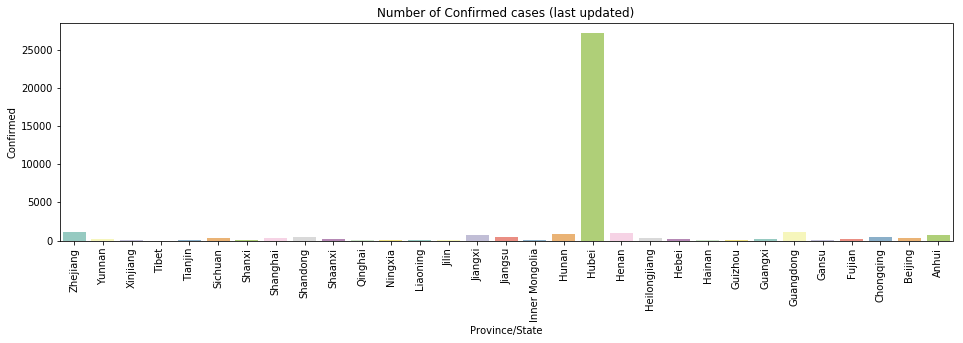

In [24]:
plot_count('Province/State', 'Confirmed', 'Confirmed cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Recovered cases

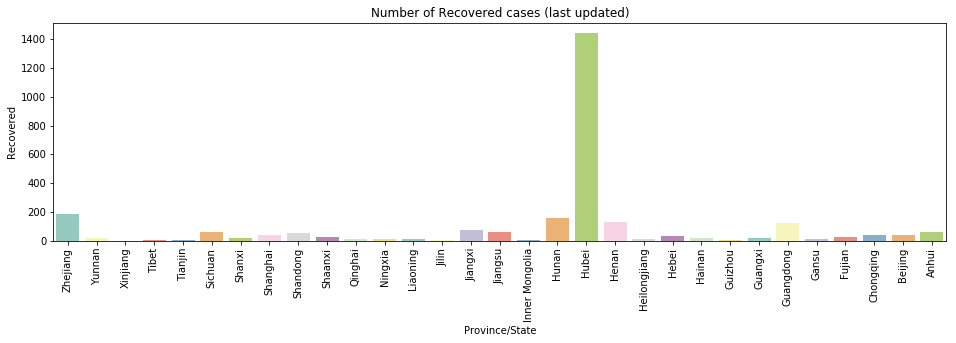

In [25]:
plot_count('Province/State', 'Recovered', 'Recovered cases (last updated)', filtered_data_last, size=4)

#### Mainland China - Deaths

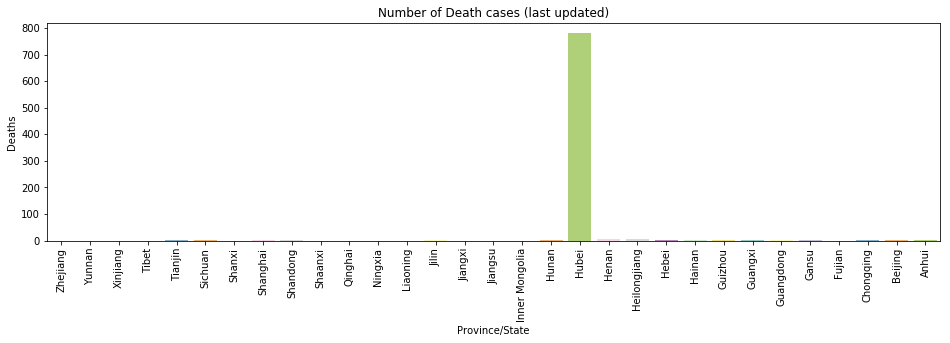

In [26]:
plot_count('Province/State', 'Deaths', 'Death cases (last updated)', filtered_data_last, size=4)

Now we will show again the confirmed cases, deaths and recovered cases, grouped by province/state in Mainland China, as evolved in time.

In [27]:
def plot_time_variation(df, y='Confirmed', hue='Province/State', size=1):
    f, ax = plt.subplots(1,1, figsize=(4*size,3*size))
    g = sns.lineplot(x="Update", y=y, hue=hue, data=df)
    plt.xticks(rotation=90)
    plt.title(f'{y} cases grouped by {hue}')
    plt.show()  

#### Mainland China - Confirmed cases - time evolution

/opt/conda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


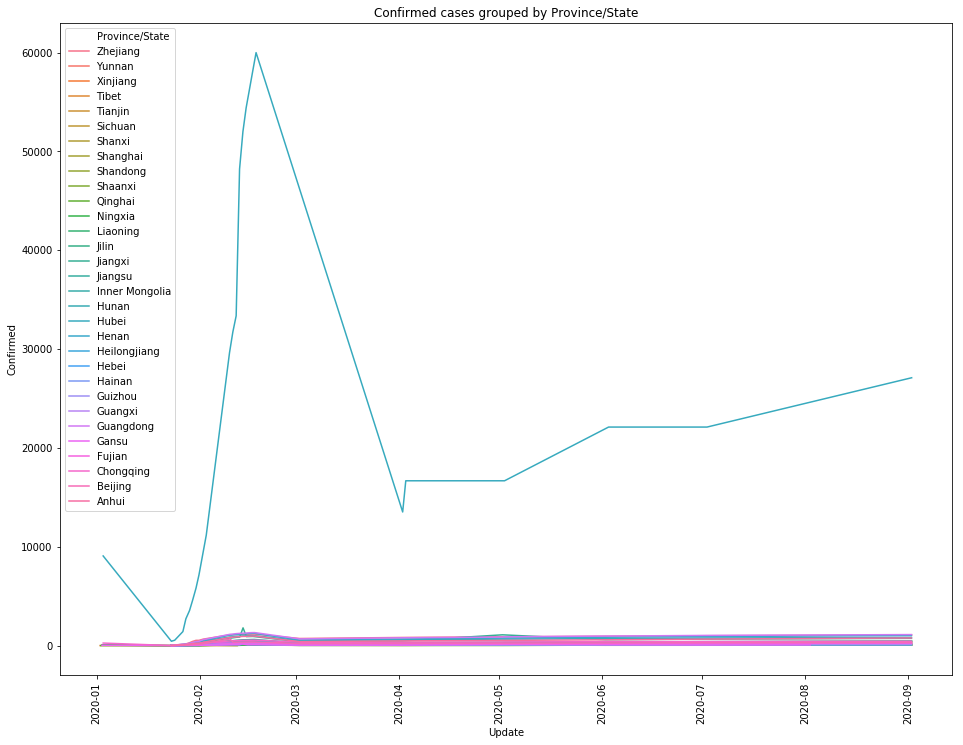

In [28]:
plot_time_variation(data_cn, size=4)

#### Mainland China - Deaths - time evolution

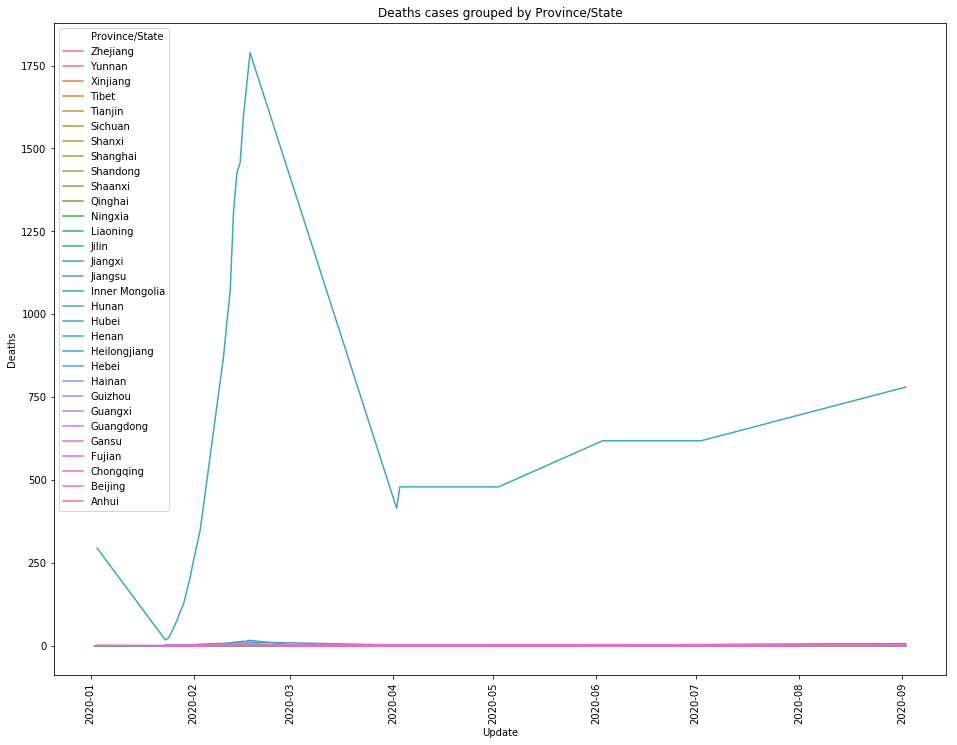

In [29]:
plot_time_variation(data_cn, y='Deaths', size=4)

#### Mainland China - Recovered cases - time evolution

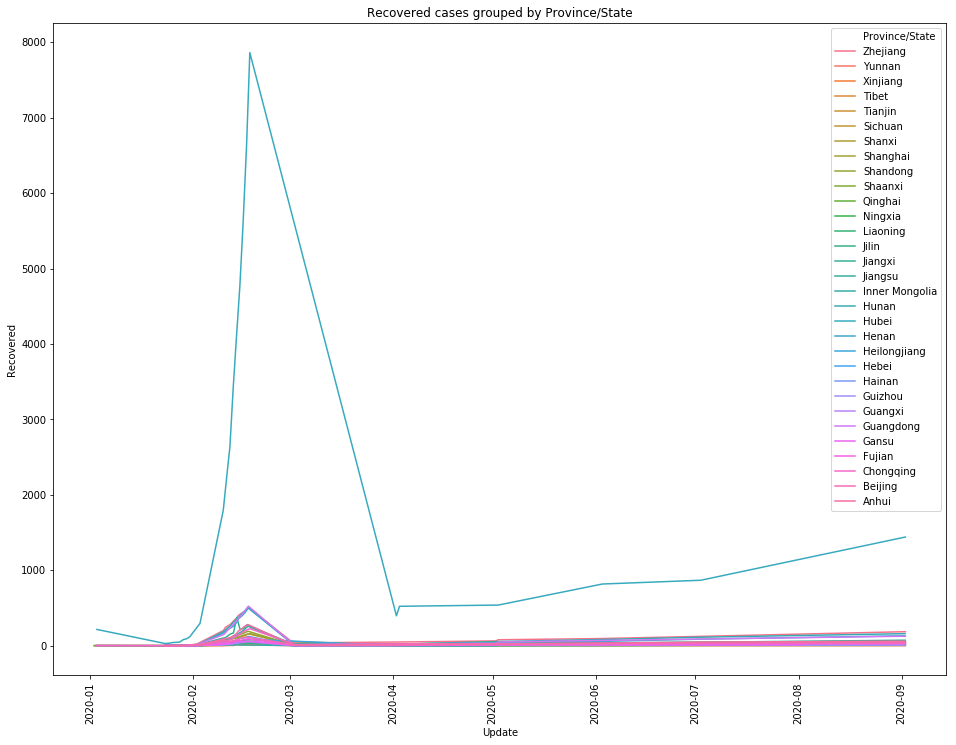

In [30]:
plot_time_variation(data_cn, y='Recovered', size=4)

Let's show only the cases outside Hubei province.

#### Mainland China - Confirmed cases (except Hubei) - time evolution

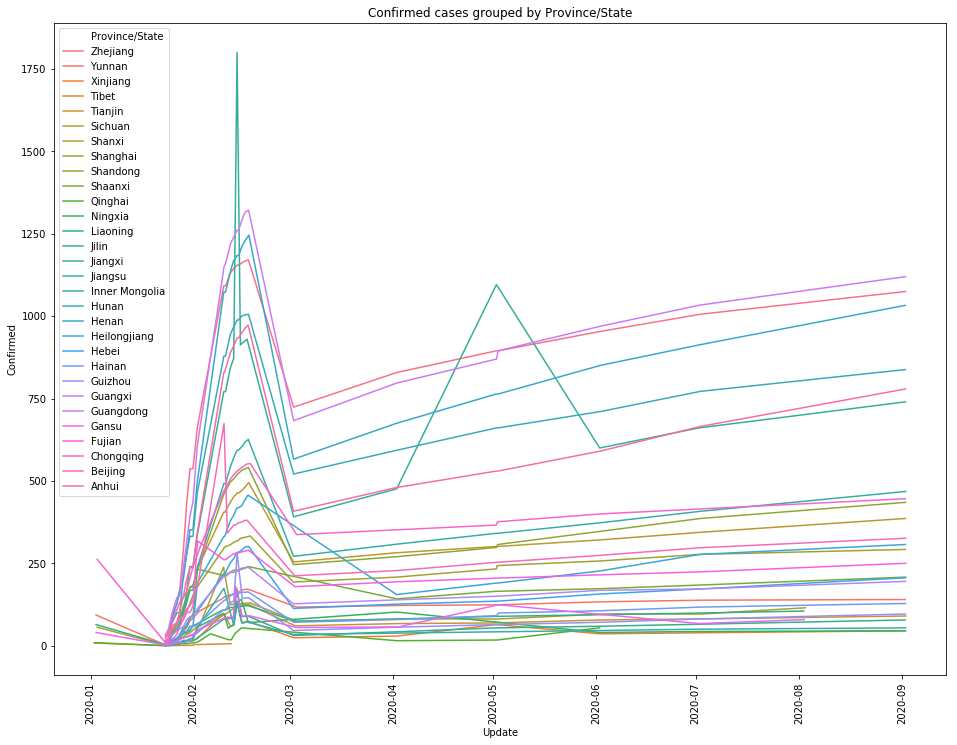

In [31]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], size=4)

#### Mainland China (except Hubei) - Deaths - time evolution

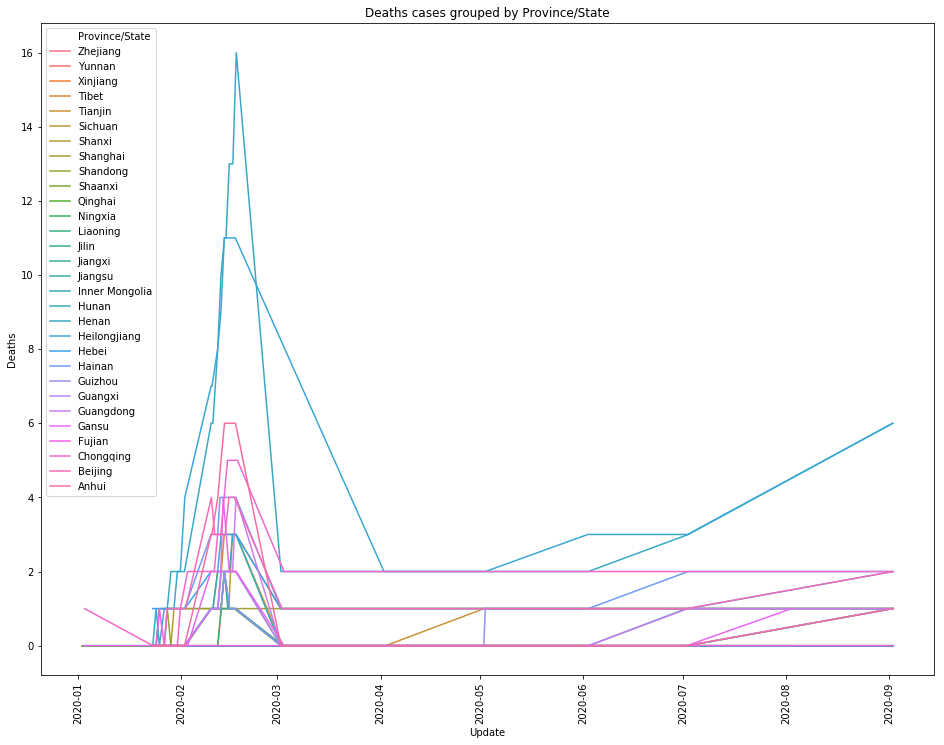

In [32]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')], y='Deaths', size=4)

#### Mainland China (except Hubei) - Recovered cases - time evolution

In [33]:
print(filtered_data_last.shape)
filtered_data_last = filtered_data_last.merge(cn_ll_df, on=['Province/State'])
print(filtered_data_last.shape)


(31, 5)
(31, 7)


In [34]:
filtered_data_last.head()

,Province/State,Update,Confirmed,Recovered,Deaths,lat,lon
0,Zhejiang,2020-09-02 03:03:00,1075.0,185.0,0.0,29.141643,119.788925
1,Yunnan,2020-09-02 00:13:00,140.0,17.0,0.0,24.475285,101.343106
2,Xinjiang,2020-09-02 01:23:00,45.0,0.0,0.0,42.524636,87.539586
3,Tibet,2020-02-12 06:43:02,6.0,6.0,0.0,30.153360,88.787868
4,Tianjin,2020-09-02 04:03:00,90.0,4.0,1.0,39.343357,117.361648


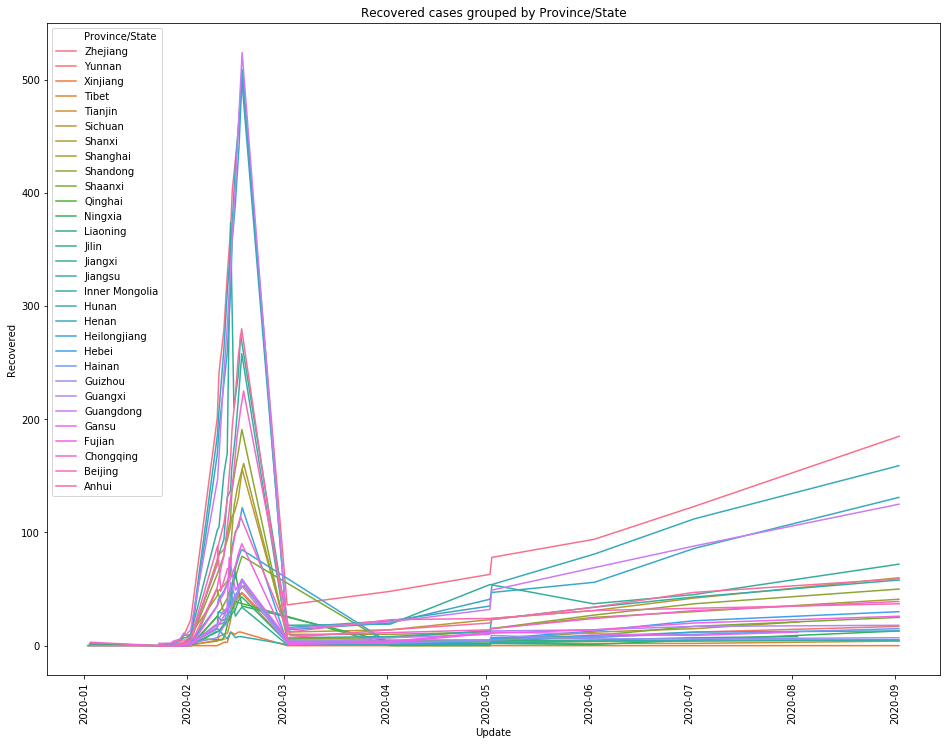

In [35]:
plot_time_variation(data_cn.loc[~(data_cn['Province/State']=='Hubei')],y='Recovered', size=4)

The following Folium group using **CircleMarker** is created using the inspiration from: https://www.kaggle.com/grebublin/coronavirus-propagation-visualization-forecast Kernel.

In [36]:
m = folium.Map(location=[30, 100], zoom_start=4)

folium.Choropleth(
    geo_data=cn_geo_data,
    name='Confirmed cases - regions',
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.05,
    line_opacity=0.3,
).add_to(m)

radius_min = 2
radius_max = 40
weight = 1
fill_opacity = 0.2

_color_conf = 'red'
group0 = folium.FeatureGroup(name='<span style=\\"color: #EFEFE8FF;\\">Confirmed cases</span>')
for i in range(len(filtered_data_last)):
    lat = filtered_data_last.loc[i, 'lat']
    lon = filtered_data_last.loc[i, 'lon']
    province = filtered_data_last.loc[i, 'Province/State']
    recovered = filtered_data_last.loc[i, 'Recovered']
    death = filtered_data_last.loc[i, 'Deaths']

    _radius_conf = np.sqrt(filtered_data_last.loc[i, 'Confirmed'])
    if _radius_conf < radius_min:
        _radius_conf = radius_min

    if _radius_conf > radius_max:
        _radius_conf = radius_max

    _popup_conf = str(province) + '\n(Confirmed='+str(filtered_data_last.loc[i, 'Confirmed']) + '\nDeaths=' + str(death) + '\nRecovered=' + str(recovered) + ')'
    folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_conf, 
                        popup = _popup_conf, 
                        color = _color_conf, 
                        fill_opacity = fill_opacity,
                        weight = weight, 
                        fill = True, 
                        fillColor = _color_conf).add_to(group0)

group0.add_to(m)
folium.LayerControl().add_to(m)
m

### Rest of the world (not China)

Let's check now the status in the rest of the world.

In [37]:
data_wd = data_df.loc[~(data_df['Country']=="Mainland China")]
data_wd = pd.DataFrame(data_wd.groupby(['Country', 'DateTime'])['Confirmed', 'Recovered', 'Deaths'].sum()).reset_index()
data_wd.columns = ['Country', 'Update', 'Confirmed', 'Recovered', 'Deaths' ]
data_wd = data_wd.sort_values(by = ['Country','Update'], ascending=False)

#### Rest of the world (not China) - Confirmed cases

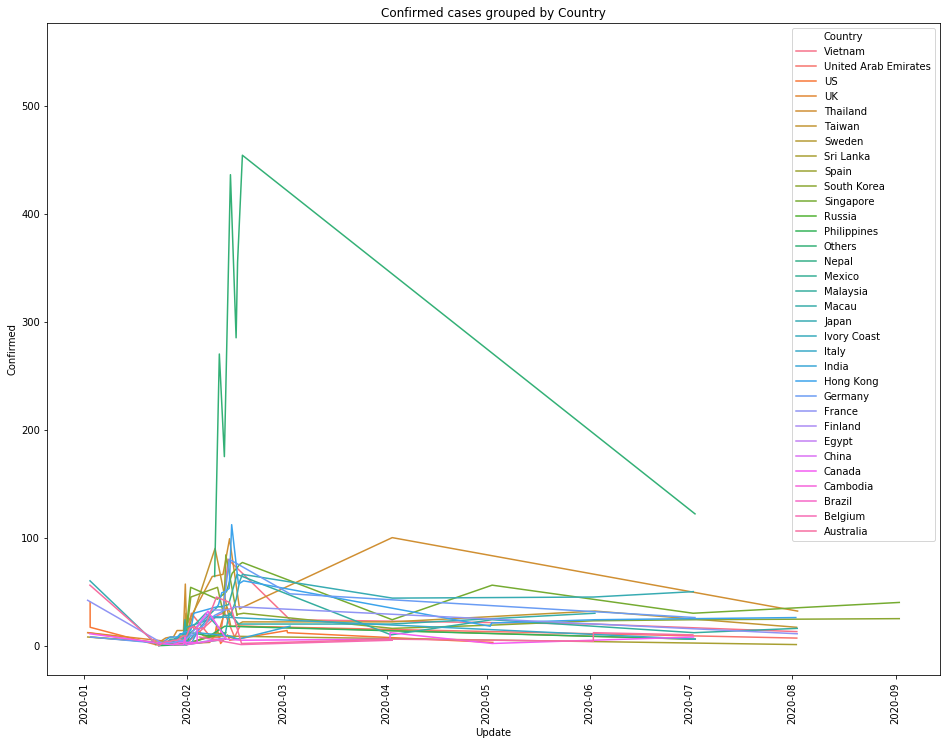

In [38]:
plot_time_variation(data_wd, y='Confirmed', hue='Country', size=4)

#### Rest of the world (not China) - Suspected

#### Rest of the world (not China) - Deaths

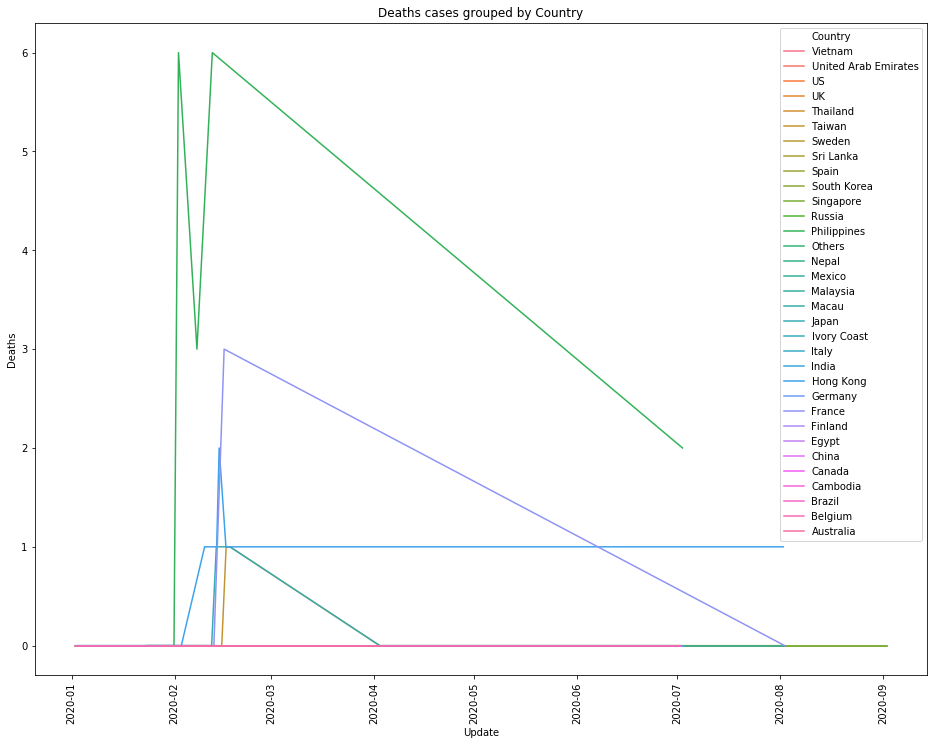

In [39]:
plot_time_variation(data_wd, y='Deaths', hue='Country', size=4)

#### Rest of the world (not China) - Recovered cases

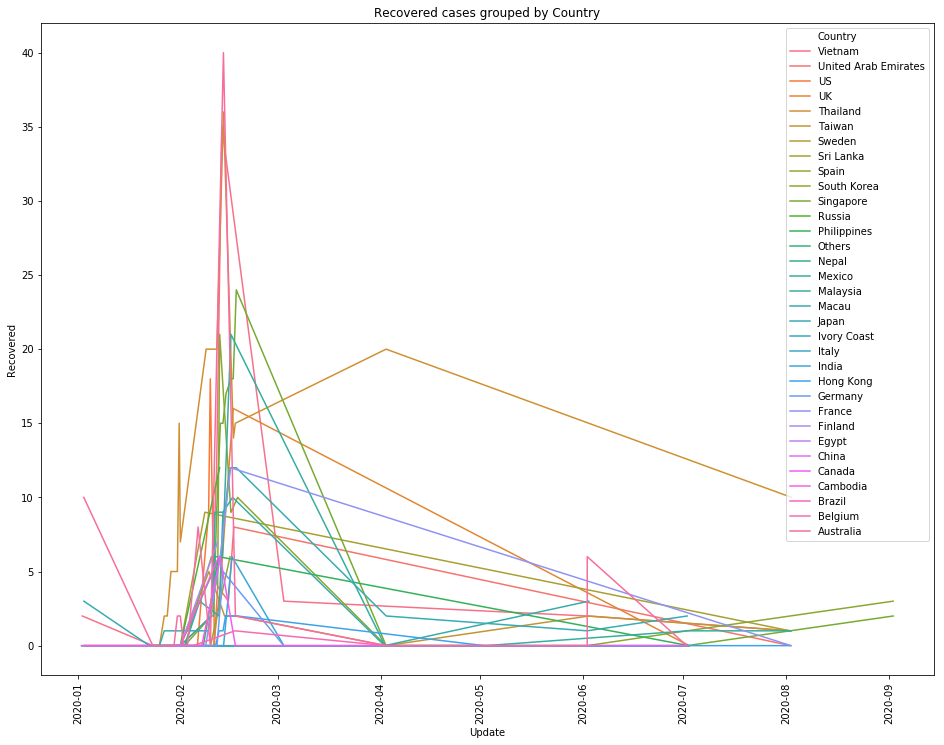

In [40]:
plot_time_variation(data_wd, y='Recovered', hue='Country', size=4)

### Rest of the World - Confirmed cases - last geographical distribution

We show on a map the distribution of confirmed cases (last information).

In [41]:
filtered_wd_data_last = data_wd.drop_duplicates(subset = ['Country'],keep='first')
filtered_wd_data_last

,Country,Update,Confirmed,Recovered,Deaths
360,Vietnam,2020-08-02 07:23:00,13.0,1.0,0.0
344,United Arab Emirates,2020-08-02 07:03:00,7.0,0.0,0.0
333,US,2020-05-02 21:53:00,3.0,0.0,0.0
308,UK,2020-07-02 18:33:00,6.0,0.0,0.0
301,Thailand,2020-08-02 12:53:00,32.0,10.0,0.0
283,Taiwan,2020-08-02 05:23:00,17.0,1.0,0.0
265,Sweden,2020-02-01 02:13:26,9.0,0.0,0.0
262,Sri Lanka,2020-08-02 03:43:00,1.0,1.0,0.0
254,Spain,2020-02-15 17:23:04,6.0,6.0,0.0
250,South Korea,2020-09-02 02:33:00,25.0,3.0,0.0


In [42]:
# check the field for country feature name; uncomment the following lines to check the country feature names
#fullJsonString = None
#with open(wd_geo_data, 'r') as f:
#    fullJsonString = f.read().encode('ascii', errors='ignore')
#fullJsonString

### Rest of the World (not China) - Confirmed Cases

In [43]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_wd_data_last,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases (not China)'
).add_to(m)

folium.LayerControl().add_to(m)
m

### All World

We show the geographical distribution of the spread of 2019 Coronavirus.

#### All World - Confirmed cases

In [44]:
data_all_wd = pd.DataFrame(data_df.groupby(['Country', 'Last Update'])['Confirmed',  'Recovered', 'Deaths'].sum()).reset_index()
data_all_wd.columns = ['Country', 'Update', 'Confirmed', 'Recovered', 'Deaths' ]
data_all_wd = data_all_wd.sort_values(by = ['Country','Update'], ascending=False)
filtered_all_wd_data_last = data_all_wd.drop_duplicates(subset = ['Country'],keep='first')
filtered_all_wd_data_last.loc[filtered_all_wd_data_last['Country']=='Mainland China', 'Country'] = 'China'
filtered_all_wd_data_last

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Country,Update,Confirmed,Recovered,Deaths
740,Vietnam,2020-08-02 07:23:00,13.0,1.0,0.0
723,United Arab Emirates,2020-08-02 07:03:00,7.0,0.0,0.0
711,US,2020-05-02 21:53:00,3.0,0.0,0.0
677,UK,2020-07-02 18:33:00,6.0,0.0,0.0
669,Thailand,2020-08-02 12:53:00,32.0,10.0,0.0
649,Taiwan,2020-08-02 05:23:00,17.0,1.0,0.0
630,Sweden,2020-02-01T02:13:26,4.0,0.0,0.0
626,Sri Lanka,2020-08-02 03:43:00,1.0,1.0,0.0
616,Spain,2020-02-15T17:23:04,6.0,6.0,0.0
611,South Korea,2020-09-02 02:33:00,25.0,3.0,0.0


In [45]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Confirmed cases'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Deaths

In [46]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='Deaths',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Deaths'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Deaths'
).add_to(m)

folium.LayerControl().add_to(m)
m

#### All World - Recovered cases

In [47]:
m = folium.Map(location=[0,0], zoom_start=2)

folium.Choropleth(
    geo_data=wd_geo_data,
    name='choropleth',
    data=filtered_all_wd_data_last,
    columns=['Country', 'Recovered'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Recovered'
).add_to(m)

folium.LayerControl().add_to(m)
m